In [1]:
import importlib_resources as resources
import sys
import glob
import pandas as pd
import threading
from datetime import datetime, timedelta
import os

#from etherscan import Etherscan
import json
import time
import requests
from hexbytes import HexBytes
#from web3 import Web3
import flatdict
from datetime import datetime
from tqdm import tqdm
import numpy as np

pd.set_option('display.max_columns', None)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
#!pip install category_encoders

In [3]:
#!pip install feature-engine

In [4]:
#!pip install xgboost

In [5]:
#!pip install chart_studio

In [6]:
#!pip install npm 

In [7]:
#!pip install nodejs

In [8]:
#!pip install nodejs

In [9]:
#!jupyter labextension install jupyterlab-plotly

In [146]:
df = pd.read_csv('./dataset.csv')
df.shape

(4914, 72)

In [139]:
df = df.drop(columns=['Unnamed: 0'])

In [144]:
df = df.drop_duplicates()

In [145]:
df[df.Target==1].shape

(99, 71)

In [147]:
df_Abn_erc20_trnsf_appr = pd.concat(map(pd.read_csv, glob.glob('./02.Data/01.Abnromal/03.ERC-20/ERC20_*.csv')))
df_Abn_erc20_trnsf_appr.head()

,Unnamed: 0,hash,blockNumber,timestamp,receiverIsContract,sender,receiver,ERC20Info_eventInfo_type,ERC20Info_eventInfo_addressApproved,ERC20Info_eventInfo_tokenAllowance,ERC20Info_eventInfo_approvedSpenderIsContract,ERC20Info_tokenAddress,ERC20Info_tokenDetails_totalSupply,ERC20Info_tokenDetails_symbol,ERC20Info_tokenDetails_name,ERC20Info_tokenDetails_decimals,ethValue,ERC20Info_eventInfo_transferReceiver,ERC20Info_eventInfo_tokenQuantity,ERC20Info_eventInfo_transferReceiverIsContract
0,0,0x7c66dab17478ed7c6b298c4d2eb32e32b77f8911e01d...,15307582.0,1.660042e+09,True,0x35663b9a8e4563eefdf852018548b4947b20fce6,0xa11bd36801d8fa4448f0ac4ea7a62e3634ce8c7c,approval,0x35663b9a8e4563eefdf852018548b4947b20fce6,1157920892373161954235709850086879078532699846...,True,0xa11bd36801d8fa4448f0ac4ea7a62e3634ce8c7c,100000000000000000000000000,abr,allbridge,18.0,0.0,NaN,NaN,NaN
1,0,0xf928f23c0d569c734a118840cf61156d38dc8198b01c...,15307545.0,1.660042e+09,True,0x35663b9a8e4563eefdf852018548b4947b20fce6,0x3845badade8e6dff049820680d1f14bd3903a5d0,approval,0x35663b9a8e4563eefdf852018548b4947b20fce6,1157920892373161954235709850086879078532699846...,True,0x3845badade8e6dff049820680d1f14bd3903a5d0,3000000000000000000000000000,sand,sand,18.0,0.0,NaN,NaN,NaN
2,0,0x76160c5ea56098ede9d9e468b02cd8dfce2270f1c183...,15307535.0,1.660042e+09,True,0x35663b9a8e4563eefdf852018548b4947b20fce6,0xdac17f958d2ee523a2206206994597c13d831ec7,approval,0x35663b9a8e4563eefdf852018548b4947b20fce6,1157920892373161954235709850086879078532699846...,True,0xdac17f958d2ee523a2206206994597c13d831ec7,32297366521996886,usdt,tether usd,6.0,0.0,NaN,NaN,NaN
3,0,0x2b0ae39332ba9d476609ccab0e44791e80490dc2d511...,15307504.0,1.660041e+09,True,0x35663b9a8e4563eefdf852018548b4947b20fce6,0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0,approval,0x35663b9a8e4563eefdf852018548b4947b20fce6,1157920892373161954235709850086879078532699846...,True,0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0,10000000000000000000000000000,matic,matic token,18.0,0.0,NaN,NaN,NaN
4,0,0x5d706fd09a1c6a00ac50a50c33d859856958827acc31...,13715896.0,1.638291e+09,True,0x35663b9a8e4563eefdf852018548b4947b20fce6,0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0,approval,0x35663b9a8e4563eefdf852018548b4947b20fce6,1157920892373161954235709850086879078532699846...,True,0x7d1afa7b718fb893db30a3abc0cfc608aacfebb0,10000000000000000000000000000,matic,matic token,18.0,0.0,NaN,NaN,NaN


In [148]:
tokens = list(df['erc20_mostSentTokenAddress_transfer'].value_counts().index)

In [149]:
token_title = (df_Abn_erc20_trnsf_appr[df_Abn_erc20_trnsf_appr['ERC20Info_tokenAddress']
                                       .isin(tokens)][['ERC20Info_tokenAddress','ERC20Info_tokenDetails_name']]
               .drop_duplicates()   
              )
token_title.shape

(24, 2)

## 1.1. Find and replace token hash to token main name:

### 1.1.1 TRANSFER - Most sent token name replacemment:

In [150]:
df = (df.merge(token_title.rename(
                            columns={'ERC20Info_tokenDetails_name':'ERC20Info_mostSentTokenName_transfer'}),
              left_on='erc20_mostSentTokenAddress_transfer',
              right_on='ERC20Info_tokenAddress',
              how='left'
             )
     )

df = df.drop(columns=['ERC20Info_tokenAddress', 'Unnamed: 0'])

### 1.1.2 APPROVAL - Most sent token name replacemment:

In [151]:
df = (df.merge(token_title.rename(
                            columns={'ERC20Info_tokenDetails_name':'ERC20Info_mostSentTokenName_approval'}),
              left_on='erc20_mostSentTokenAddress_approval',
              right_on='ERC20Info_tokenAddress',
              how='left'
             )
     )

df = df.drop(columns=['ERC20Info_tokenAddress'])

### 1.1.3 OTHER - Most sent token name replacemment:

In [152]:
df = (df.merge(token_title.rename(
                            columns={'ERC20Info_tokenDetails_name':'ERC20Info_mostSentTokenName_other'}),
              left_on='erc20_mostSentTokenAddress_other',
              right_on='ERC20Info_tokenAddress',
              how='left'
             )
     )

df = df.drop(columns=['ERC20Info_tokenAddress'])

In [153]:
df = df.drop(columns=['erc20_mostSentTokenAddress_transfer', 'erc20_mostSentTokenAddress_approval', 'erc20_mostSentTokenAddress_other'])

In [154]:
df.head()

,total_transactions_other,total_uniqueReceivedFromAddresses_other,total_uniqueSentToAddresses_other,time_avgBetweenReceivedTxn_other,time_avgBetweenTxn_other,time_diffBetweenFirstAndLastSent_other,time_diffBetweenFirstAndLastTxn_other,erc20_uniqueTokenAddressesSent_other,erc20_uniqueTokenAddressesReceived_other,erc20_mostReceivedTokenAddress_other,erc20_uniqueUnknownValueTokens_other,erc20_transactionsWithUnknownValueTokens_other,walletAddress,total_transactions_approval,total_etherSent_approval,total_etherReceived_approval,total_etherSentToContract_approval,total_sentTxn_approval,total_receivedTxn_approval,total_sentToContractTxn_approval,total_uniqueReceivedFromAddresses_approval,total_uniqueSentToAddresses_approval,time_avgBetweenTxn_approval,time_diffBetweenFirstAndLastTxn_approval,erc20_uniqueTokenAddressesSent_approval,erc20_uniqueTokenAddressesReceived_approval,erc20_uniqueUnknownValueTokens_approval,erc20_transactionsWithUnknownValueTokens_approval,total_transactions_transfer,total_etherSent_transfer,total_etherReceived_transfer,total_etherSentToContract_transfer,total_sentTxn_transfer,total_receivedTxn_transfer,total_sentToContractTxn_transfer,total_uniqueReceivedFromAddresses_transfer,total_uniqueSentToAddresses_transfer,time_avgBetweenTxn_transfer,time_diffBetweenFirstAndLastTxn_transfer,erc20_uniqueTokenAddressesSent_transfer,erc20_uniqueTokenAddressesReceived_transfer,erc20_uniqueUnknownValueTokens_transfer,erc20_transactionsWithUnknownValueTokens_transfer,received:minValue,received:maxValue,received:avgValue,sent:minValue,sent:maxValue,sent:avgValue,sentToContract:minValue,sentToContract:maxValue,sentToContract:avgValue,total:transactions,total:etherSent,total:etherReceived,total:etherSentToContract,total:sentTxn,total:receivedTxn,total:sentToContractTxn,total:uniqueReceivedFromAddresses,total:uniqueSentToAddresses,time:avgBetweenSentTxn,time:avgBetweenReceivedTxn,time:avgBetweenTxn,time:diffBetweenFirstAndLastSent,time:diffBetweenFirstAndLastReceived,time:diffBetweenFirstAndLastTxn,Target,ERC20Info_mostSentTokenName_transfer,ERC20Info_mostSentTokenName_approval,ERC20Info_mostSentTokenName_other
0,5.0,0.0,1.0,NaN,14 days 00:10:46.400000,NaN,70 days 00:53:52,1.0,0.0,NaN,1.0,5.0,0x3d56c1734fab2126f3a6a58bcf57c25b1e99372b,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4 days 00:26:06.500000,8 days 00:52:13,2.0,0.0,2.0,2.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3 days 20:43:04.954545454,84 days 23:47:49,3.0,0.0,3.0,22.0,0.010000,1.560714,0.330983,0.0,1.572896,0.049766,0.0,0.0,0.0,173.0,8.310931,1.985900,0.0,167.0,6.0,106.0,3.0,40.0,0 days 13:01:21.556886227,11 days 20:08:57.500000,0 days 12:34:15.606936416,90 days 14:47:00,71 days 00:53:45,90 days 14:47:00,0,NaN,tether usd,wrapped ether
1,1.0,0.0,1.0,NaN,0 days 00:00:00,NaN,0 days 00:00:00,1.0,0.0,NaN,1.0,1.0,0x3da2e7ed450f747cfaac81c3d32605beb83de70c,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0 days 00:00:00,0 days 00:00:00,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.337500,0.041197,0.0,0.319000,0.018373,0.0,0.0,0.0,63.0,0.863536,0.659159,0.0,47.0,16.0,27.0,4.0,21.0,1 days 19:26:18.489361702,5 days 01:27:07.250000,1 days 08:24:23.317460317,85 days 01:36:29,80 days 23:13:56,85 days 01:36:29,0,NaN,wrapped ether,wrapped ether
2,2.0,0.0,1.0,NaN,2 days 00:20:46,NaN,4 days 00:41:32,1.0,0.0,NaN,1.0,2.0,0x3de56d8f088b6767557dde6eb2d83bf74df6bec3,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2 days 20:49:01.333333333,17 days 04:54:08,5.0,0.0,5.0,6.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0 days 22:25:44,7 days 11:25:52,2.0,0.0,2.0,8.0,0.000000,1.107007,0.447358,0.0,1.860855,0.155038,0.0,0.0,0.0,87.0,10.852685,7.605094,0.0,70.0,17.0,35.0,8.0,19.0,0 days 09:21:26.514285714,4 days 04:20:02,0 days 07:31:44.091954022,27 days 07:00:56,71 days 01:40:34,27 days 07:00:56,0,NaN,wrapped ether,wrapped ether
3,12.0,0.0,1.0,NaN,6 days 17:09:23.166666666,NaN,80 days 13:52:38,1.0,0.0,NaN,1.0,12.0,0x3dadf855b9e30e63bee10ec4d92cbfe789e5f8a8,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,11 day

## 1.2 Remove null value columns:

In [155]:
df = df.drop(columns=['time_avgBetweenReceivedTxn_other','time_diffBetweenFirstAndLastSent_other',
                      'erc20_mostReceivedTokenAddress_other']
            )

In [156]:
df = df.drop(columns=['total_uniqueReceivedFromAddresses_other', 'erc20_uniqueTokenAddressesReceived_other',
                      'total_etherSent_approval', 'total_etherReceived_approval', 'total_etherSentToContract_approval',
                      'total_sentTxn_approval', 'total_receivedTxn_approval', 'total_sentToContractTxn_approval',
                      'total_uniqueReceivedFromAddresses_approval', 'total_uniqueSentToAddresses_approval',
                      'erc20_uniqueTokenAddressesReceived_approval', 'total_etherSent_transfer', 'total_etherReceived_transfer',
                      'total_etherSentToContract_transfer', 'total_sentTxn_transfer', 'total_receivedTxn_transfer',
                      'total_sentToContractTxn_transfer', 'sentToContract:minValue', 'sentToContract:maxValue',
                      'sentToContract:avgValue', 'total:etherSentToContract']
            )

In [157]:
#****df.erc20_uniqueTokenAddressesSent_other.value_counts()
#****df.total_uniqueSentToAddresses_other.value_counts()
#****df.erc20_uniqueUnknownValueTokens_other.value_counts()
#****df.total_uniqueReceivedFromAddresses_transfer.value_counts()
#****df.erc20_uniqueTokenAddressesReceived_transfer.value_counts()

## 1.3 Time deltas to hours (float)

In [158]:
time_col = [x for x in list(df.columns) if 'time' in x]

for col in time_col:
    df[col] = pd.to_timedelta(df[col])
    df[col] = (df[col] / np.timedelta64(1, 'h')).fillna(0)

In [159]:
df.columns = df.columns.str.replace(":", "_trx_", regex=True)

In [160]:
df.head()

,total_transactions_other,total_uniqueSentToAddresses_other,time_avgBetweenTxn_other,time_diffBetweenFirstAndLastTxn_other,erc20_uniqueTokenAddressesSent_other,erc20_uniqueUnknownValueTokens_other,erc20_transactionsWithUnknownValueTokens_other,walletAddress,total_transactions_approval,time_avgBetweenTxn_approval,time_diffBetweenFirstAndLastTxn_approval,erc20_uniqueTokenAddressesSent_approval,erc20_uniqueUnknownValueTokens_approval,erc20_transactionsWithUnknownValueTokens_approval,total_transactions_transfer,total_uniqueReceivedFromAddresses_transfer,total_uniqueSentToAddresses_transfer,time_avgBetweenTxn_transfer,time_diffBetweenFirstAndLastTxn_transfer,erc20_uniqueTokenAddressesSent_transfer,erc20_uniqueTokenAddressesReceived_transfer,erc20_uniqueUnknownValueTokens_transfer,erc20_transactionsWithUnknownValueTokens_transfer,received_trx_minValue,received_trx_maxValue,received_trx_avgValue,sent_trx_minValue,sent_trx_maxValue,sent_trx_avgValue,total_trx_transactions,total_trx_etherSent,total_trx_etherReceived,total_trx_sentTxn,total_trx_receivedTxn,total_trx_sentToContractTxn,total_trx_uniqueReceivedFromAddresses,total_trx_uniqueSentToAddresses,time_trx_avgBetweenSentTxn,time_trx_avgBetweenReceivedTxn,time_trx_avgBetweenTxn,time_trx_diffBetweenFirstAndLastSent,time_trx_diffBetweenFirstAndLastReceived,time_trx_diffBetweenFirstAndLastTxn,Target,ERC20Info_mostSentTokenName_transfer,ERC20Info_mostSentTokenName_approval,ERC20Info_mostSentTokenName_other
0,5.0,1.0,336.179556,1680.897778,1.0,1.0,5.0,0x3d56c1734fab2126f3a6a58bcf57c25b1e99372b,2.0,96.435139,192.870278,2.0,2.0,2.0,22.0,0.0,3.0,92.718043,2039.796944,3.0,0.0,3.0,22.0,0.010000,1.560714,0.330983,0.0,1.572896,0.049766,173.0,8.310931,1.985900,167.0,6.0,106.0,3.0,40.0,13.022655,284.149306,12.571002,2174.783333,1704.895833,2174.783333,0,NaN,tether usd,wrapped ether
1,1.0,1.0,0.000000,0.000000,1.0,1.0,1.0,0x3da2e7ed450f747cfaac81c3d32605beb83de70c,1.0,0.000000,0.000000,1.0,1.0,1.0,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.337500,0.041197,0.0,0.319000,0.018373,63.0,0.863536,0.659159,47.0,16.0,27.0,4.0,21.0,43.438469,121.452014,32.406477,2041.608056,1943.232222,2041.608056,0,NaN,wrapped ether,wrapped ether
2,2.0,1.0,48.346111,96.692222,1.0,1.0,2.0,0x3de56d8f088b6767557dde6eb2d83bf74df6bec3,6.0,68.817037,412.902222,5.0,5.0,6.0,8.0,0.0,2.0,22.428889,179.431111,2.0,0.0,2.0,8.0,0.000000,1.107007,0.447358,0.0,1.860855,0.155038,87.0,10.852685,7.605094,70.0,17.0,35.0,8.0,19.0,9.357365,100.333889,7.528914,655.015556,1705.676111,655.015556,0,NaN,wrapped ether,wrapped ether
3,12.0,1.0,161.156435,1933.877222,1.0,1.0,12.0,0x3dadf855b9e30e63bee10ec4d92cbfe789e5f8a8,7.0,268.888413,1882.218889,3.0,3.0,7.0,3.0,0.0,3.0,430.148056,1290.444167,2.0,0.0,2.0,3.0,0.000000,0.075000,0.013454,0.0,0.100000,0.002794,475.0,1.240571,0.417069,444.0,31.0,289.0,18.0,222.0,4.967608,51.051138,4.643406,2205.617778,1582.585278,2205.617778,0,usd coin,usd coin,wrapped ether
4,2.0,1.0,33.223889,66.447778,1.0,1.0,2.0,0x3dd387da5b32160f3f4c8fb2ec0adb415cad41f1,3.0,256.126204,768.378611,3.0,3.0,3.0,6.0,0.0,2.0,300.604074,1803.624444,2.0,0.0,2.0,6.0,0.001396,0.116400,0.023671,0.0,0.147342,0.013586,56.0,0.611380,0.260386,45.0,11.0,16.0,8.0,12.0,44.814932,166.900631,36.011999,2016.671944,1835.906944,2016.671944,0,NaN,NaN,wrapped ether


In [161]:
df.shape

(4914, 47)

In [162]:
df = df.drop_duplicates()

In [163]:
df.columns

Index(['total_transactions_other', 'total_uniqueSentToAddresses_other',
       'time_avgBetweenTxn_other', 'time_diffBetweenFirstAndLastTxn_other',
       'erc20_uniqueTokenAddressesSent_other',
       'erc20_uniqueUnknownValueTokens_other',
       'erc20_transactionsWithUnknownValueTokens_other', 'walletAddress',
       'total_transactions_approval', 'time_avgBetweenTxn_approval',
       'time_diffBetweenFirstAndLastTxn_approval',
       'erc20_uniqueTokenAddressesSent_approval',
       'erc20_uniqueUnknownValueTokens_approval',
       'erc20_transactionsWithUnknownValueTokens_approval',
       'total_transactions_transfer',
       'total_uniqueReceivedFromAddresses_transfer',
       'total_uniqueSentToAddresses_transfer', 'time_avgBetweenTxn_transfer',
       'time_diffBetweenFirstAndLastTxn_transfer',
       'erc20_uniqueTokenAddressesSent_transfer',
       'erc20_uniqueTokenAddressesReceived_transfer',
       'erc20_uniqueUnknownValueTokens_transfer',
       'erc20_transactionsWith

In [166]:
df['total_trx_transactions'].sum()

877379.0

# 2. Modelling

In [28]:
#Organize the featres (categorical and numerical)
model_config = dict()
model_config['pipeline_features'] = dict()
model_config['pipeline_features']['categorical_cols'] = ['ERC20Info_mostSentTokenName_transfer', 
                                                         'ERC20Info_mostSentTokenName_approval',
                                                         'ERC20Info_mostSentTokenName_other']
model_config['pipeline_features']['numeric_cols'] = ['total_transactions_other', 'total_uniqueSentToAddresses_other',
                                                     'time_avgBetweenTxn_other', 'time_diffBetweenFirstAndLastTxn_other',
                                                     'erc20_uniqueTokenAddressesSent_other','erc20_uniqueUnknownValueTokens_other',
                                                     'erc20_transactionsWithUnknownValueTokens_other',
                                                     'total_transactions_approval', 'time_avgBetweenTxn_approval',
                                                     'time_diffBetweenFirstAndLastTxn_approval','erc20_uniqueTokenAddressesSent_approval',
                                                     'erc20_uniqueUnknownValueTokens_approval','erc20_transactionsWithUnknownValueTokens_approval',
                                                     'total_transactions_transfer','total_uniqueReceivedFromAddresses_transfer',
                                                     'total_uniqueSentToAddresses_transfer', 'time_avgBetweenTxn_transfer',
                                                     'time_diffBetweenFirstAndLastTxn_transfer','erc20_uniqueTokenAddressesSent_transfer',
                                                     'erc20_uniqueTokenAddressesReceived_transfer','erc20_uniqueUnknownValueTokens_transfer',
                                                     'erc20_transactionsWithUnknownValueTokens_transfer','received_trx_minValue', 'received_trx_maxValue',
                                                     'received_trx_avgValue', 'sent_trx_minValue', 'sent_trx_maxValue',
                                                     'sent_trx_avgValue', 'total_trx_transactions', 'total_trx_etherSent',
                                                     'total_trx_etherReceived', 'total_trx_sentTxn', 'total_trx_receivedTxn',
                                                     'total_trx_sentToContractTxn', 'total_trx_uniqueReceivedFromAddresses',
                                                     'total_trx_uniqueSentToAddresses', 'time_trx_avgBetweenSentTxn',
                                                     'time_trx_avgBetweenReceivedTxn', 'time_trx_avgBetweenTxn',
                                                     'time_trx_diffBetweenFirstAndLastSent',
                                                     'time_trx_diffBetweenFirstAndLastReceived','time_trx_diffBetweenFirstAndLastTxn']

model_config['pipeline_features']['datetime_cols']= ''

model_config['Target'] = 'Target'
model_config['X_drop_columns'] = ['Target', 'walletAddress']

In [29]:
model_config

{'pipeline_features': {'categorical_cols': ['ERC20Info_mostSentTokenName_transfer',
   'ERC20Info_mostSentTokenName_approval',
   'ERC20Info_mostSentTokenName_other'],
  'numeric_cols': ['total_transactions_other',
   'total_uniqueSentToAddresses_other',
   'time_avgBetweenTxn_other',
   'time_diffBetweenFirstAndLastTxn_other',
   'erc20_uniqueTokenAddressesSent_other',
   'erc20_uniqueUnknownValueTokens_other',
   'erc20_transactionsWithUnknownValueTokens_other',
   'total_transactions_approval',
   'time_avgBetweenTxn_approval',
   'time_diffBetweenFirstAndLastTxn_approval',
   'erc20_uniqueTokenAddressesSent_approval',
   'erc20_uniqueUnknownValueTokens_approval',
   'erc20_transactionsWithUnknownValueTokens_approval',
   'total_transactions_transfer',
   'total_uniqueReceivedFromAddresses_transfer',
   'total_uniqueSentToAddresses_transfer',
   'time_avgBetweenTxn_transfer',
   'time_diffBetweenFirstAndLastTxn_transfer',
   'erc20_uniqueTokenAddressesSent_transfer',
   'erc20_uniqu

## 2.1 Split Dataset

In [30]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = model_config['X_drop_columns']).copy()
y = df['Target']

X_train, X_test, Y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=32)

In [31]:
X_train.shape

(3860, 45)

In [32]:
Y_train.value_counts(normalize=True)

0    0.979016
1    0.020984
Name: Target, dtype: float64

In [135]:
Y_train.shape

(3860,)

In [33]:
y_test.value_counts(normalize=True)

0    0.981366
1    0.018634
Name: Target, dtype: float64

## 2.2 Pipeline Definition

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import category_encoders as ce

class DtypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_cols, categorical_cols=[], datetime_cols=[]):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
        self.datetime_cols = datetime_cols
        self.dtypes = {k:np.float64 for k in self.numeric_cols}
        self.dtypes.update({k:'category' for k in self.categorical_cols})
        self.dtypes.update({k:'datetime64[ns]' for k in self.datetime_cols})

    def fit(self, X, y=None):
        return self

    # @timeit
    #TODO: this method is one of the bottlenecks in terms of response time
    def transform(self, X, y=None):
        """
        This method transforms the data types of all DataFrame columns, according to the three categories defined in the settings.yml:
            - numeric_cols are casted as np.float64 dtype
            - categorical_cols are casted as 'category' dtype
            - datetime_cols are casted as 'datetime64[ns]' dtype

        Args:
            X: input DataFrame

        Returns:
            X_: casted DataFrame
        """     
        df_cols = X.columns
        
        numeric_cols = [x for x in self.numeric_cols if x in df_cols]
        categorical_cols = [x for x in self.categorical_cols if x in df_cols]
        datetime_cols = [x for x in self.datetime_cols if x in df_cols]
        
        self.dtypes = {k:np.float64 for k in numeric_cols}
        self.dtypes.update({k:'category' for k in categorical_cols})
        self.dtypes.update({k:'datetime64[ns]' for k in datetime_cols})
                
        return X.astype(self.dtypes)

    
class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    # @timeit
    def transform(self, X, y=None):
        """
        This method calculates custom features

        Args:
            X: input DataFrame

        Returns:
            X_: DataFrame with new features calculated
        """
        #X['remaining_balance'] = (X.balance - X.amount)
        #X['tea_tenure'] = (pd.to_datetime(X.created_at_pst) - pd.to_datetime(X.known_since)).dt.days
        
        return X

class CatboostEncoder(BaseEstimator, TransformerMixin):

    def __init__(self, categorical_cols):
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        self.encoder = ce.cat_boost.CatBoostEncoder(
            cols=self.categorical_cols,
            random_state=42,
        )
        perm = np.random.permutation(len(X)) 
        
        self.encoder.fit(
            X = X[self.categorical_cols].astype("str").iloc[perm].reset_index(drop=True), 
            y = y.iloc[perm].reset_index(drop=True)
        )

        return self

    # @timeit
    def transform(self, X, y=None):
        """
        This method implements categorical features encoding with CatBoostEncoder

        Args:
            X: input DataFrame

        Returns:
            X_: DataFrame with categorical columns encoded
        """
        transformed_features = self.encoder.transform(
            X=X[self.categorical_cols]
        ).rename(columns={i: i + "_cb" for i in self.categorical_cols})

        X = X.drop(self.categorical_cols, axis=1)
        
        return pd.merge(X, transformed_features, right_index=True, left_index=True)
    
class autoencoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, autoencoder_path=False, features_path=False, scaler_path=False):
        self.autoencoder_path = autoencoder_path
        self.features_path = features_path
        self.scaler_path = scaler_path


    def fit(self, X, y=None):
        return self

    def get_autoencoder(self, X):
        """
        The last step must be a classifier with fit/predict_proba methods.

        Example of steps:
            - data types casting objects
            - missing data imputation strategy
            - scalers
            - custom feature engineering
            - categorical encoders
            - stacking models
            - sklearn estimators

        Returns:
            autoencoder: keras autoencoder model (Arq).
        """
        n_features = self.X.shape[1]
        
        # model
        encoder = models.Sequential(name='encoder')
        encoder.add(layer=layers.Dense(units=40, activation=activations.relu, input_shape=[n_features]))
        encoder.add(layers.Dropout(0.1))
        encoder.add(layer=layers.Dense(units=20, activation=activations.relu, input_shape=[n_features]))
        encoder.add(layer=layers.Dense(units=5, activation=activations.relu))

        decoder = models.Sequential(name='decoder')
        decoder.add(layer=layers.Dense(units=20, activation=activations.relu, input_shape=[10]))
        decoder.add(layer=layers.Dense(units=40, activation=activations.relu))
        decoder.add(layers.Dropout(0.1))
        decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))

        autoencoder = models.Sequential([encoder, decoder])
        
        autoencoder.compile(loss=losses.MSE,
                            optimizer = optimizers.Adam(),
                            metrics=[metrics.mean_squared_error])

        es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=12, restore_best_weights=True)
        
        return autoencoder, es
    
    
    def autoencoder_train(self, X=None, y=None):
        
        df = pd.DataFrame(X)
        df = df.fillna(0)
        df['anomaly'] = y
        #self.avoid = df.columns[df.eq(0).mean()>0.9]
        #df = df.drop(columns=df.columns[df.eq(0).mean()>0.9])
        
        normal_events = df[df['anomaly'] == 0]
        abnormal_events = df[df['anomaly'] == 1]

        normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']
        abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

        scaler = preprocessing.MinMaxScaler()
        scaler.fit(df.drop('anomaly', 1))

        scaled_data = scaler.transform(normal_events)
        
        # 80% percent of dataset is designated to training
        train_data, test_data = model_selection.train_test_split(scaled_data, test_size=0.2)
        
        print(np.argwhere(np.isnan(train_data)))
        
        history = self.autoencoder.fit(x=train_data, y=train_data, epochs=1, verbose=True, validation_data=(test_data, test_data), callbacks=[self.es])
        
        return history
    
    def ae_rmse(self, X, autoencoder_path):
        
        df = pd.DataFrame(X)
        df = df.fillna(0)
        
        features= joblib.load(self.features_path)
        df = df[features]
        
        if self.scaler_path:
            self.scaler = joblib.load(self.scaler_path)
        
        
        if self.scaler is None:
            scaler = preprocessing.MinMaxScaler()
            scaler.fit(df.drop('anomaly', 1))
            self.scaler = scaler

        scaled_data = self.scaler.transform(df)
        
        autoencoder = keras.models.load_model(autoencoder_path)

        ae_predicted = autoencoder.predict(x=scaled_data)
        
        ae_rmse = np.zeros(df.shape[0], dtype=float)

        for i in range(df.shape[0]):
            ae_rmse[i] = np.sqrt(np.mean(np.square(df.iloc[i] - ae_predicted[i])))
            
        X['ae_spl_rmse'] = ae_rmse
        
        return X
    
    def transform(self, X):
        
        #if self.autoencoder is None:
        #    self.autoencoder, self.es = self.get_autoencoder(X)
        
        #    self.history = self.autoencoder_train(X, self.y)
        
        X = self.ae_rmse(X, self.autoencoder_path)
        
        return X
    

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

import category_encoders as ce
from feature_engine import imputation as msi
from feature_engine.imputation import ArbitraryNumberImputer

imputation_pipeline = Pipeline([
    ('categorical_imputer', msi.CategoricalImputer(variables=model_config['pipeline_features']['categorical_cols'],
                            fill_value='missing')),
    ('numeric_imputer', ArbitraryNumberImputer(arbitrary_number=0,
                                                   variables=model_config['pipeline_features'][
                                                       'numeric_cols']))
])     

pipe = Pipeline(steps=[
    ("dtype_transformer",
     DtypeTransformer(categorical_cols=model_config['pipeline_features']['categorical_cols'],
                      numeric_cols=model_config['pipeline_features']['numeric_cols'],
                      datetime_cols=model_config['pipeline_features']['datetime_cols'])),
    ("imputation_pipeline", imputation_pipeline),
    ("feature_transformer", FeatureTransformer()),
    ("cb_encoder", CatboostEncoder(categorical_cols=model_config['pipeline_features']['categorical_cols']))
#    ("Autoencoder", autoencoder(autoencoder_path='', 
#                                features_path='', 
#                                scaler_path='' )),
#    ("xgboost", xgb.sklearn.XGBClassifier(objective='binary:logistic', eval_metric=['auc', 'aucpr', 'error', 'logloss'], random_state=42, use_label_encoder=False))
])

In [36]:
X_train_trsf = pipe.fit_transform(X_train, y=Y_train)

In [37]:
X_test_trsf = pipe.transform(X_test)

## 2.3 T-SNE visualization

In [38]:
import numpy as np
from sklearn.manifold import TSNE

df_TSNE = X_train_trsf.copy()
df_TSNE['Target'] = Y_train

X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(df_TSNE)
X_embedded.shape

(3860, 2)

In [39]:
df_TSNE['t_sne_x'] = X_embedded[:, 0]
df_TSNE['t_sne_y'] = X_embedded[:, 1]
#df_TSNE['t_sne_z'] = X_embedded[:, 2]

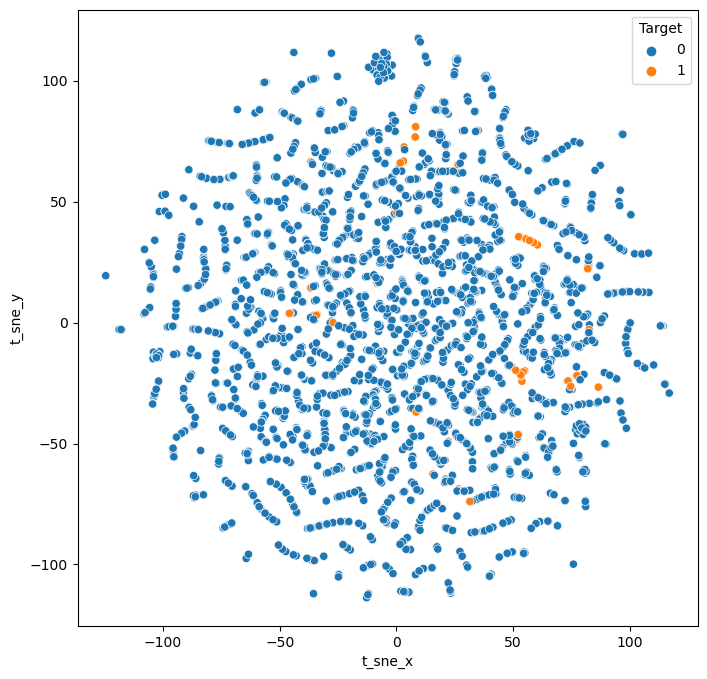

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_TSNE, hue='Target', x='t_sne_x', y='t_sne_y')
plt.show()

## 2.4 Autoencoder

In [41]:
from sklearn import decomposition, preprocessing, model_selection
from keras import models, layers, activations, losses, optimizers, metrics
from keras.callbacks import EarlyStopping

Using MXNet backend
/home/ec2-user/anaconda3/envs/mxnet_p38/lib/python3.8/site-packages/keras/__init__.py:28: DeprecationWarning: MXNet support in Keras is going to be discontinued and v2.2.4.3 is the last release as multi-backend Keras has been discontinued . It is recommended to consider switching to MXNet Gluon. More information can be found here: https://github.com/awslabs/keras-apache-mxnet
  warnings.warn("MXNet support in Keras is going to be discontinued and v2.2.4.3 is the last "


In [42]:
ae_features = ['received_trx_minValue', 'received_trx_maxValue', 'received_trx_avgValue',
               'sent_trx_minValue', 'sent_trx_maxValue', 'sent_trx_avgValue',
               'total_trx_transactions', 'total_trx_etherSent', 'total_trx_etherReceived',
               'total_trx_sentTxn', 'total_trx_receivedTxn', 'total_trx_sentToContractTxn',
               'total_trx_uniqueReceivedFromAddresses', 'total_trx_uniqueSentToAddresses',
               'time_trx_avgBetweenSentTxn', 'time_trx_avgBetweenReceivedTxn',
               'time_trx_avgBetweenTxn', 'time_trx_diffBetweenFirstAndLastSent',
               'time_trx_diffBetweenFirstAndLastReceived','time_trx_diffBetweenFirstAndLastTxn']

In [98]:
X = X_train_trsf[ae_features].copy()
n_features = X.shape[1]
        
# model
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=20, activation=activations.relu, input_shape=[n_features]))
encoder.add(layers.Dropout(0.1))
encoder.add(layer=layers.Dense(units=7, activation=activations.relu, input_shape=[n_features]))
encoder.add(layer=layers.Dense(units=2, activation=activations.relu))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=7, activation=activations.relu, input_shape=[2]))
decoder.add(layer=layers.Dense(units=20, activation=activations.relu))
decoder.add(layers.Dropout(0.1))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(loss=losses.MSE,
                    optimizer = optimizers.Adam(),
                    metrics=[metrics.mean_squared_error])

es = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=7, restore_best_weights=True)

    

[19:59:20] ../src/executor/graph_executor.cc:1991: Subgraph backend MKLDNN is activated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
[19:59:20] ../src/executor/graph_executor.cc:1991: Subgraph backend MKLDNN is activated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.spa

In [103]:
del(df)
df = pd.DataFrame(X)
df = df.fillna(0)
df['anomaly'] = Y_train
#self.avoid = df.columns[df.eq(0).mean()>0.9]
#df = df.drop(columns=df.columns[df.eq(0).mean()>0.9])

normal_events = df[df['anomaly'] == 0]
abnormal_events = df[df['anomaly'] == 1]

normal_events = normal_events.loc[:, normal_events.columns != 'anomaly']
abnormal_events = abnormal_events.loc[:, abnormal_events.columns != 'anomaly']

scaler = preprocessing.MinMaxScaler()
scaler.fit(df.drop('anomaly', 1))

scaled_data = scaler.transform(normal_events)

# 80% percent of dataset is designated to training
train_data, test_data = model_selection.train_test_split(scaled_data, test_size=0.2)

print(np.argwhere(np.isnan(train_data)))

history = autoencoder.fit(x=train_data, y=train_data, epochs=1, verbose=True, validation_data=(test_data, test_data), callbacks=[es])


[]
Train on 3023 samples, validate on 756 samples
Epoch 1/1
 384/3023 [==>...........................] - ETA: 1s - loss: 0.0274 - mean_squared_error: 0.0274

Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `sci

 832/3023 [=======>......................] - ETA: 0s - loss: 0.0272 - mean_squared_error: 0.0272

Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `sci

1504/3023 [=============>................] - ETA: 0s - loss: 0.0268 - mean_squared_error: 0.0268

Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `sci

1952/3023 [==================>...........] - ETA: 0s - loss: 0.0263 - mean_squared_error: 0.0263

Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `sci

2752/3023 [==========================>...] - ETA: 0s - loss: 0.0250 - mean_squared_error: 0.0250

Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `sci

3023/3023 [==============================] - 1s 363us/step - loss: 0.0246 - mean_squared_error: 0.0246 - val_loss: 0.0212 - val_mean_squared_error: 0.0212


Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `sci

In [104]:
scaler = preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop('anomaly', 1))
#self.scaler = scaler

#scaled_data = scaler.fit_transform(df)#self.scaler.transform(df)

#autoencoder = keras.models.load_model(autoencoder_path)

ae_predicted = autoencoder.predict(x=scaled_data)

Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `sci

In [105]:
ae_rmse = np.zeros(df.shape[0], dtype=float)

for i in range(df.shape[0]):
    ae_rmse[i] = np.sqrt(np.mean(np.square(df.drop('anomaly', 1).iloc[i] - ae_predicted[i])))

X['ae_spl_rmse'] = ae_rmse

## 2.4 XGBoost Modelling

In [108]:
X_train_trsf['ae_score'] = np.log(X['ae_spl_rmse'])

test_scaled = scaler.transform(X_test_trsf[ae_features])
ae_predicted = autoencoder.predict(x=test_scaled)
ae_rmse = np.zeros(X_test_trsf.shape[0], dtype=float)

for i in range(X_test_trsf.shape[0]):
    ae_rmse[i] = np.sqrt(np.mean(np.square(df.drop('anomaly', 1).iloc[i] - ae_predicted[i])))


X_test_trsf['ae_score'] = np.log(X['ae_spl_rmse'])


Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
Please use `csr_matrix` from the `sci

In [109]:
X_train_trsf.head()

,total_transactions_other,total_uniqueSentToAddresses_other,time_avgBetweenTxn_other,time_diffBetweenFirstAndLastTxn_other,erc20_uniqueTokenAddressesSent_other,erc20_uniqueUnknownValueTokens_other,erc20_transactionsWithUnknownValueTokens_other,total_transactions_approval,time_avgBetweenTxn_approval,time_diffBetweenFirstAndLastTxn_approval,erc20_uniqueTokenAddressesSent_approval,erc20_uniqueUnknownValueTokens_approval,erc20_transactionsWithUnknownValueTokens_approval,total_transactions_transfer,total_uniqueReceivedFromAddresses_transfer,total_uniqueSentToAddresses_transfer,time_avgBetweenTxn_transfer,time_diffBetweenFirstAndLastTxn_transfer,erc20_uniqueTokenAddressesSent_transfer,erc20_uniqueTokenAddressesReceived_transfer,erc20_uniqueUnknownValueTokens_transfer,erc20_transactionsWithUnknownValueTokens_transfer,received_trx_minValue,received_trx_maxValue,received_trx_avgValue,sent_trx_minValue,sent_trx_maxValue,sent_trx_avgValue,total_trx_transactions,total_trx_etherSent,total_trx_etherReceived,total_trx_sentTxn,total_trx_receivedTxn,total_trx_sentToContractTxn,total_trx_uniqueReceivedFromAddresses,total_trx_uniqueSentToAddresses,time_trx_avgBetweenSentTxn,time_trx_avgBetweenReceivedTxn,time_trx_avgBetweenTxn,time_trx_diffBetweenFirstAndLastSent,time_trx_diffBetweenFirstAndLastReceived,time_trx_diffBetweenFirstAndLastTxn,ERC20Info_mostSentTokenName_transfer_cb,ERC20Info_mostSentTokenName_approval_cb,ERC20Info_mostSentTokenName_other_cb,ae_score
889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,4.0,0.000000,0.000000,0.000000,0.000000,0.002967,0.001483,2.0,0.002967,0.000000,2.0,0.0,1.0,0.0,2.0,3.983750,0.000000,3.983750,7.967500,0.000000,7.967500,0.002098,0.012668,0.008483,1.053834
2706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.016942,0.016942,0.016942,1.0,0.016942,0.000000,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007728,0.012668,0.008483,-0.943450
2769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002000,0.049907,0.025954,0.000000,0.000000,0.000000,2.0,0.000000,0.051907,0.0,2.0,0.0,1.0,0.0,0.000000,0.727083,0.727083,0.000000,1.454167,1.454167,0.007728,0.012668,0.008483,-0.214821
4650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.053000,0.053000,0.053000,0.057165,0.057165,0.057165,2.0,0.057165,0.053000,1.0,1.0,0.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007728,0.012668,0.008483,-0.460771
2568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008574,0.044270,0.029022,0.008499,0.044120,0.028859,12.0,0.173152,0.174134,6.0,6.0,0.0,1.0,1.0,306.946852,306.946713,153.473426,1841.681111,1841.680278,1841.681111,0.007728,0.012668,0.008483,6.580038


In [110]:
import xgboost as xgb


params =  {
  'subsample': 1,
  'scale_pos_weight': 47, #2%
  'n_estimators': 200,
  'max_depth': 4,
  'learning_rate': 0.1,
  'colsample_bytree': 0.4,
  'colsample_bylevel': 0.3,
  'lambda': 0.5,
  'min_split_loss': 0.1,
  'alpha': 0.5
}

model = xgb.sklearn.XGBClassifier(objective='binary:logistic', 
                          eval_metric=['logloss', 'auc', 'aucpr', 'error'], 
                          random_state=42,
                          use_label_encoder=False)

model.set_params(**params)
eval_set = [(X_train_trsf, Y_train), (X_test_trsf, y_test)]
model.fit(X_train_trsf, y=Y_train, eval_set=eval_set, early_stopping_rounds=15)

[0]	validation_0-logloss:0.62742	validation_0-auc:0.95933	validation_0-aucpr:0.65458	validation_0-error:0.13756	validation_1-logloss:0.63172	validation_1-auc:0.89328	validation_1-aucpr:0.48601	validation_1-error:0.16874
[1]	validation_0-logloss:0.57788	validation_0-auc:0.97393	validation_0-aucpr:0.76001	validation_0-error:0.11425	validation_1-logloss:0.58308	validation_1-auc:0.96308	validation_1-aucpr:0.70164	validation_1-error:0.13768
[2]	validation_0-logloss:0.52639	validation_0-auc:0.98195	validation_0-aucpr:0.79787	validation_0-error:0.08420	validation_1-logloss:0.53332	validation_1-auc:0.96689	validation_1-aucpr:0.76481	validation_1-error:0.10248
[3]	validation_0-logloss:0.48674	validation_0-auc:0.98278	validation_0-aucpr:0.83754	validation_0-error:0.03497	validation_1-logloss:0.49695	validation_1-auc:0.97773	validation_1-aucpr:0.75279	validation_1-error:0.05590
[4]	validation_0-logloss:0.44892	validation_0-auc:0.98332	validation_0-aucpr:0.85704	validation_0-error:0.07694	validati

`use_label_encoder` is deprecated in 1.7.0.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[6]	validation_0-logloss:0.38402	validation_0-auc:0.98970	validation_0-aucpr:0.89873	validation_0-error:0.03212	validation_1-logloss:0.39492	validation_1-auc:0.99221	validation_1-aucpr:0.84747	validation_1-error:0.05590
[7]	validation_0-logloss:0.36125	validation_0-auc:0.98930	validation_0-aucpr:0.89477	validation_0-error:0.02306	validation_1-logloss:0.37313	validation_1-auc:0.99238	validation_1-aucpr:0.85676	validation_1-error:0.03313
[8]	validation_0-logloss:0.33961	validation_0-auc:0.99006	validation_0-aucpr:0.90231	validation_0-error:0.02176	validation_1-logloss:0.35198	validation_1-auc:0.99467	validation_1-aucpr:0.88122	validation_1-error:0.03313
[9]	validation_0-logloss:0.32164	validation_0-auc:0.99108	validation_0-aucpr:0.90598	validation_0-error:0.02254	validation_1-logloss:0.33419	validation_1-auc:0.99531	validation_1-aucpr:0.88554	validation_1-error:0.03520
[10]	validation_0-logloss:0.30477	validation_0-auc:0.99092	validation_0-aucpr:0.90547	validation_0-error:0.01736	validat

XGBClassifier(alpha=0.5, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=0.3, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False,
              eval_metric=['logloss', 'auc', 'aucpr', 'error'],
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda=0.5,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, min_split_loss=0.1,
              missing=nan, monotone_constraints=None, n_estimators=200,
              n_jobs=None, ...)

In [111]:
# plot learning curve
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot


# make predictions for test data
y_pred = model.predict(X_test_trsf)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.96%


In [52]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.subplots as sp
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)  

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = np.arange(0, 166)

fig = make_subplots(rows=2, cols=2,
                    subplot_titles=("Log Loss", "Classification Error", "Classification AUC", "Classification AUC Precision/Recall"),
                    column_widths=[0.5, 0.5],
                    specs = [[{}, {}],
                             [{}, {}]
                            ],
                    horizontal_spacing = 0.1
                   #shared_yaxes=True
                   )

# plot log loss
#fig, ax = pyplot.subplots()
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['logloss'], name='Log Loss train'), row=1, col=1)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['logloss'], name='Log Loss test'), row=1, col=1)
fig.update_yaxes(title_text='Log Loss', row=1, col=1)
fig.update_layout(title='XGBoost Eval metrics')

fig.update_layout(legend=dict(yanchor="top", y=.99, xanchor="right", x=1.2),
                           legend_font_size=10, 
                           width=800, height=800)

# plot classification error
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['error'], name='Classification Error train'), row=1, col=2)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['error'], name='Classification Error test'), row=1, col=2)
fig.update_yaxes(title_text='Classification Error', row=1, col=2)


fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['auc'], name='AUC train'), row=2, col=1)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['auc'], name='AUC test'), row=2, col=1)
fig.update_yaxes(title_text='Classification Error', row=1, col=2)


fig.add_trace(go.Scatter(x=x_axis, y=results['validation_0']['aucpr'], name='Precision Recall train'), row=2, col=2)
fig.add_trace(go.Scatter(x=x_axis, y=results['validation_1']['aucpr'], name='Precision Recall test'), row=2, col=2)
fig.update_yaxes(title_text='Classification Error', row=1, col=2)
#pyplot.ylabel('Classification AUC Precision/Recall')
#pyplot.title('XGBoost Classification AUC Precision/Recall')
fig.show()

/home/ec2-user/anaconda3/envs/mxnet_p38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/home/ec2-user/anaconda3/envs/mxnet_p38/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [112]:
train_df = X_train.copy()
train_df['Target'] = Y_train 
train_df['y_pred_prob'] = model.predict_proba(X_train_trsf)[:, 1]
test_df = X_test.copy()
test_df['Target'] = y_test
test_df['y_pred_prob'] = model.predict_proba(X_test_trsf)[:, 1]

In [113]:
train_df['y_pred'] = model.predict(X_train_trsf)
test_df['y_pred'] = model.predict(X_test_trsf)

In [128]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

def plot_roc_auc(df, Target, y_pred, ax):

    fpr_xgb, tpr_xgb, thresholds = roc_curve(df[Target],df[y_pred])
    roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
    
    ax.plot(fpr_xgb, tpr_xgb, lw = 4, label = 'ROC AUC: {:.2f}'.format(roc_auc_xgb))
    ax.plot([0, 1], [0, 1], linestyle = '--', color = (0.6, 0.6, 0.6),label = 'random guessing')
    ax.plot([0, 0, 1], [0, 1, 1], linestyle = ':', color = 'black', label = 'perfect performance')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('false positive rate')
    ax.set_ylabel('true positive rate')
    ax.set_title('Receiver Operator Characteristic')
    ax.legend(loc = "lower right")
    
def plot_conf_matrix(df, Target, y_pred, return_name, ax):

    conf_matrix = confusion_matrix(df[Target], df[y_pred])
    
    sns.heatmap(conf_matrix, xticklabels=['Ok', return_name], yticklabels=['Ok', return_name], annot=True, fmt="d", ax=ax, cmap="GnBu")
    ax.set_title("Confusion matrix")
    ax.set_ylabel('True class')
    ax.set_xlabel('Predicted class')
    
def plot_prec_recall(df, Target, y_pred, return_name, ax):
    
    average_precision = average_precision_score(df[Target], df[y_pred])
    precision, recall, _ = precision_recall_curve(df[Target], df[y_pred])
    
    ax.step(recall, precision, color='b', alpha=0.2, where='post')
    ax.fill_between(recall,precision,step='post',alpha=0.2,color='b')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision', labelpad=-0.5)
    ax.set_ylim([0.0,1.05])
    ax.set_ylim([0.0,1.05])
    ax.set_title('Precision-Recall curve: PR={0:0.2f}'.format(average_precision))
    

def plot_density(y_pred, y_true, ax=None, title='Density Plot'):
    plt_df = pd.DataFrame({'pred': y_pred, 'true': y_true})
    sns.distplot(
        plt_df[plt_df['true'] == 1]['pred'],
        hist=True,
        kde=False,
        norm_hist=True,
        label="True",
        color= "#8031a7",
        ax=ax
    )
    sns.distplot(
        plt_df[plt_df['true'] == 0]['pred'],
        hist=True,
        kde=False,
        norm_hist=True,
        label="False",
        color="#3d807c",
        ax=ax
    )
    ax.set_title(title, fontsize=12, fontweight="bold", color='black')
    ax.set_xlabel("Score", fontsize=12, labelpad=2, color='black')
    ax.set_ylabel("Density", fontsize=12, labelpad=2, color='black')
    ax.tick_params(colors='black') 


def model_plot_metrics_eval(test_df, train_df, Target, y_pred, y_pred_prob, return_name):

    # Precision-Recall
    average_precision_train = average_precision_score(train_df[Target],train_df[y_pred_prob])
    precision_train, recall_train, _train = precision_recall_curve(train_df[Target],train_df[y_pred_prob])
    
    ##Test Metrics:##
    conf_matrix_test = confusion_matrix(test_df[Target], test_df[y_pred])
    fpr_xgb_test, tpr_xgb_test, thresholds_test = roc_curve(test_df[Target],test_df[y_pred])
    roc_auc_xgb_test = auc(fpr_xgb_test, tpr_xgb_test)
    # Precision-Recall
    average_precision_test = average_precision_score(test_df[Target],test_df[y_pred_prob])
    precision_test, recall_test, _train = precision_recall_curve(test_df[Target],test_df[y_pred_prob])
    
    ##Plot:##
    #fig, axs = plt.subplots(3, 3, figsize=(16, 16))#, sharex=True, sharey=True)

    fig, axs = plt.subplots(nrows=3, ncols=1, constrained_layout=True, figsize = (12, 12))
    fig.suptitle('Performance Metrics')

    # clear subplots
    for ax in axs:
        ax.remove()

    # add subfigure per subplot
    gridspec = axs[0].get_subplotspec().get_gridspec()
    subfigs = [fig.add_subfigure(gs) for gs in gridspec]

    for row, subfig in enumerate(subfigs):
        subfig.suptitle(f'Density Plot')

        if row == 0:
            subfig.suptitle(f'Train Dataset')
            # create 1x3 subplots per subfig
            axs = subfig.subplots(nrows=1, ncols=3)
            #ROC AUC Train
            plot_roc_auc(train_df, Target, y_pred, axs[0])
            # Precision-Recall
            plot_prec_recall(train_df, Target, y_pred, return_name, axs[1])
            #Conf Matrix Train
            plot_conf_matrix(train_df, Target, y_pred, return_name, axs[2])
            
        elif row == 1:
            subfig.suptitle(f'Test Dataset')
            # create 1x3 subplots per subfig
            axs = subfig.subplots(nrows=1, ncols=3)
            #ROC AUC Train
            plot_roc_auc(test_df, Target, y_pred, axs[0])
            # Precision-Recall
            plot_prec_recall(test_df, Target, y_pred, return_name, axs[1])
            #Conf Matrix Train
            plot_conf_matrix(test_df, Target, y_pred, return_name, axs[2])
            
        else:
            # create 1x3 subplots per subfig
            axs = subfig.subplots(nrows=1, ncols=2)
            #density train
            plot_density(y_true=train_df[Target], y_pred=train_df[y_pred], ax=axs[0])
    
            #density test
            plot_density(y_true=test_df[Target], y_pred=test_df[y_pred], ax=axs[1])

    plt.show()
    
    print("Train Accuracy: ",accuracy_score(train_df[Target], train_df[y_pred]))
    print("Train Recall: ",recall_score(train_df[Target], train_df[y_pred]))
    print("Train Precision: ",precision_score(train_df[Target], train_df[y_pred]))
    
    print("\nTest Accuracy: ",accuracy_score(test_df[Target], test_df[y_pred]))
    print("Test Recall: ",recall_score(test_df[Target], test_df[y_pred]))
    print("Test Precision: ",precision_score(test_df[Target], test_df[y_pred]))


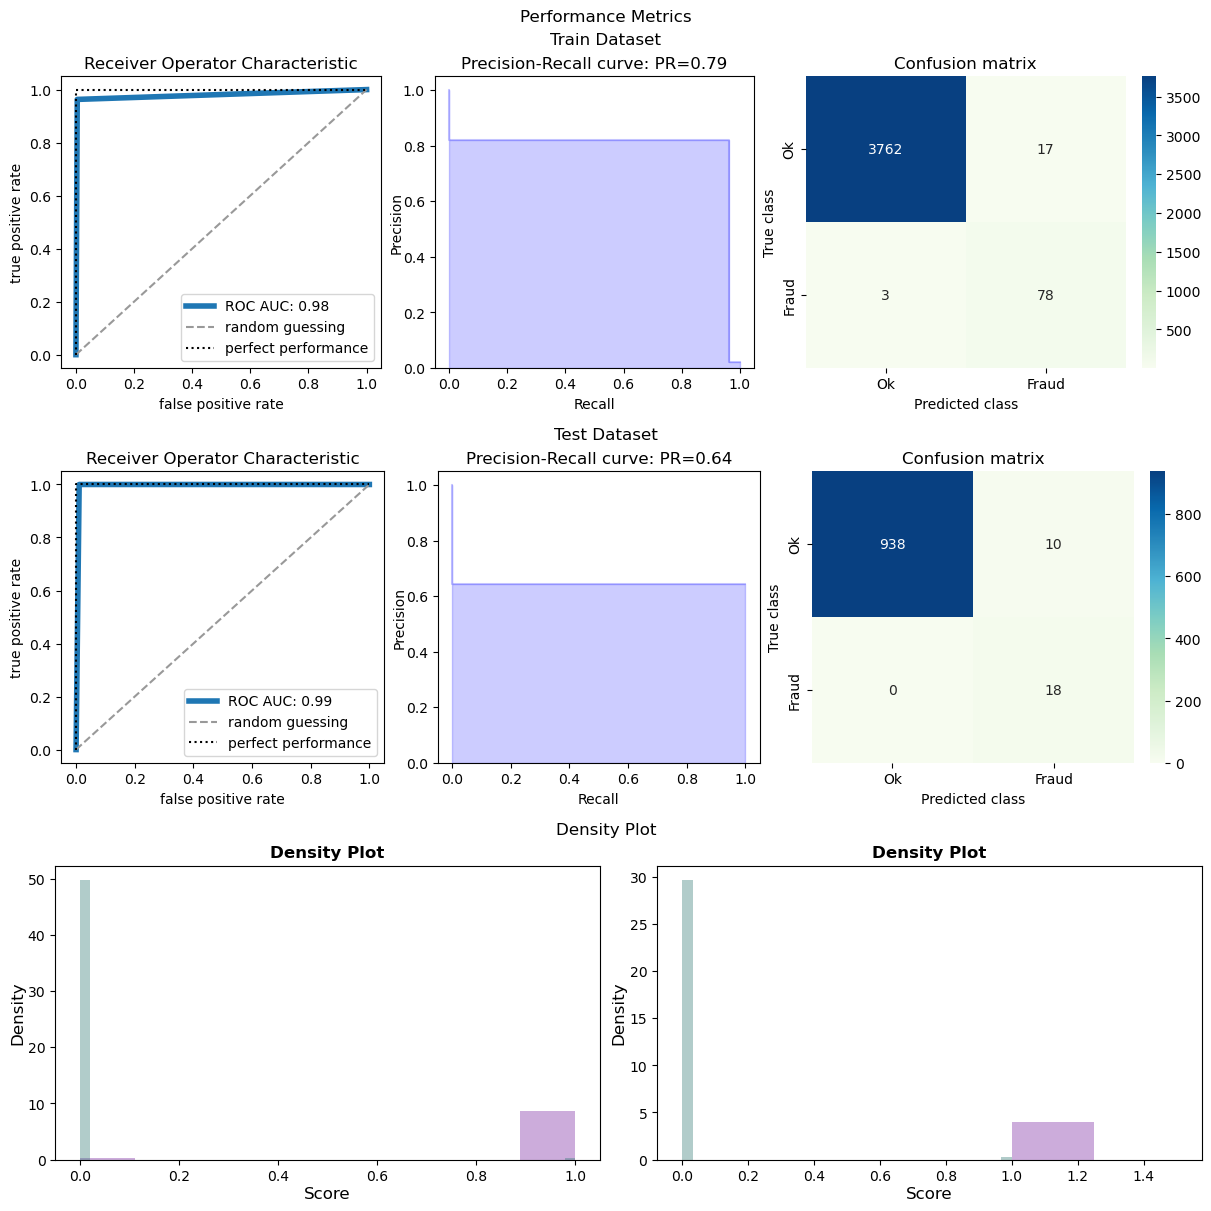

Train Accuracy:  0.9948186528497409
Train Recall:  0.9629629629629629
Train Precision:  0.8210526315789474

Test Accuracy:  0.989648033126294
Test Recall:  1.0
Test Precision:  0.6428571428571429


In [129]:
model_plot_metrics_eval(test_df, train_df, 'Target', 'y_pred', 'y_pred_prob', 'Fraud')

Logistic: f1=0.783 auc=0.968


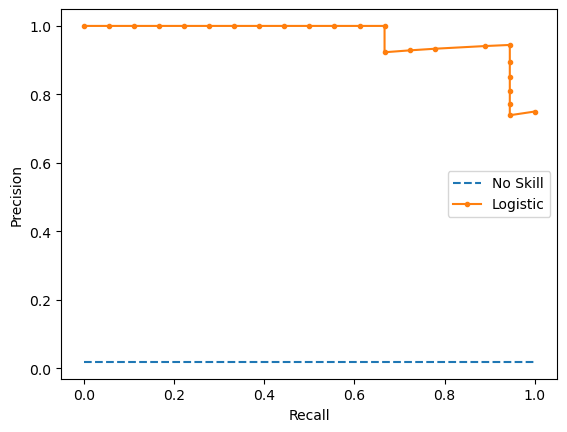

In [122]:
# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot

lr_precision, lr_recall, _ = precision_recall_curve(test_df['Target'], test_df['y_pred_prob'])
lr_f1, lr_auc = f1_score(test_df['Target'], test_df['y_pred']), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(test_df[test_df['Target']==1]['Target']) / len(test_df['Target'])
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [57]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [58]:
import shap

def plot_shap_xgb(X_train_trsf):
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train_trsf)
    shap.summary_plot(shap_values, X_train_trsf)
    
    return shap_values


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

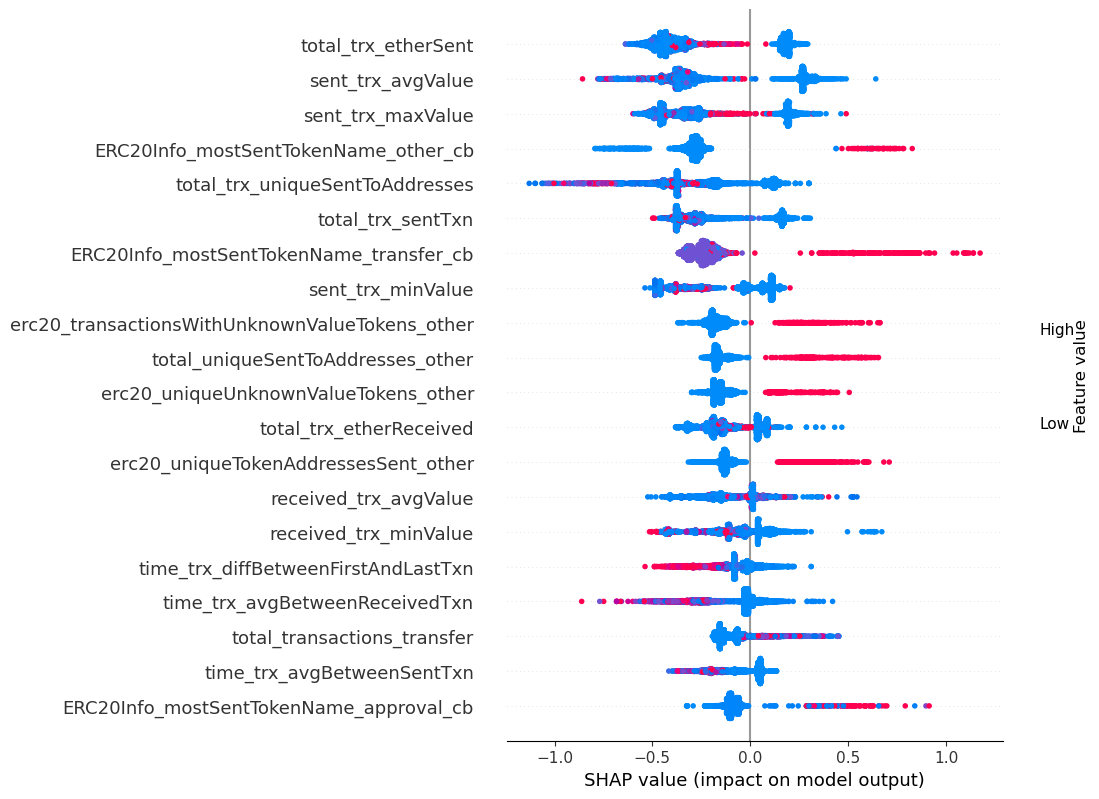

In [59]:
shap_values = plot_shap_xgb(X_train_trsf)

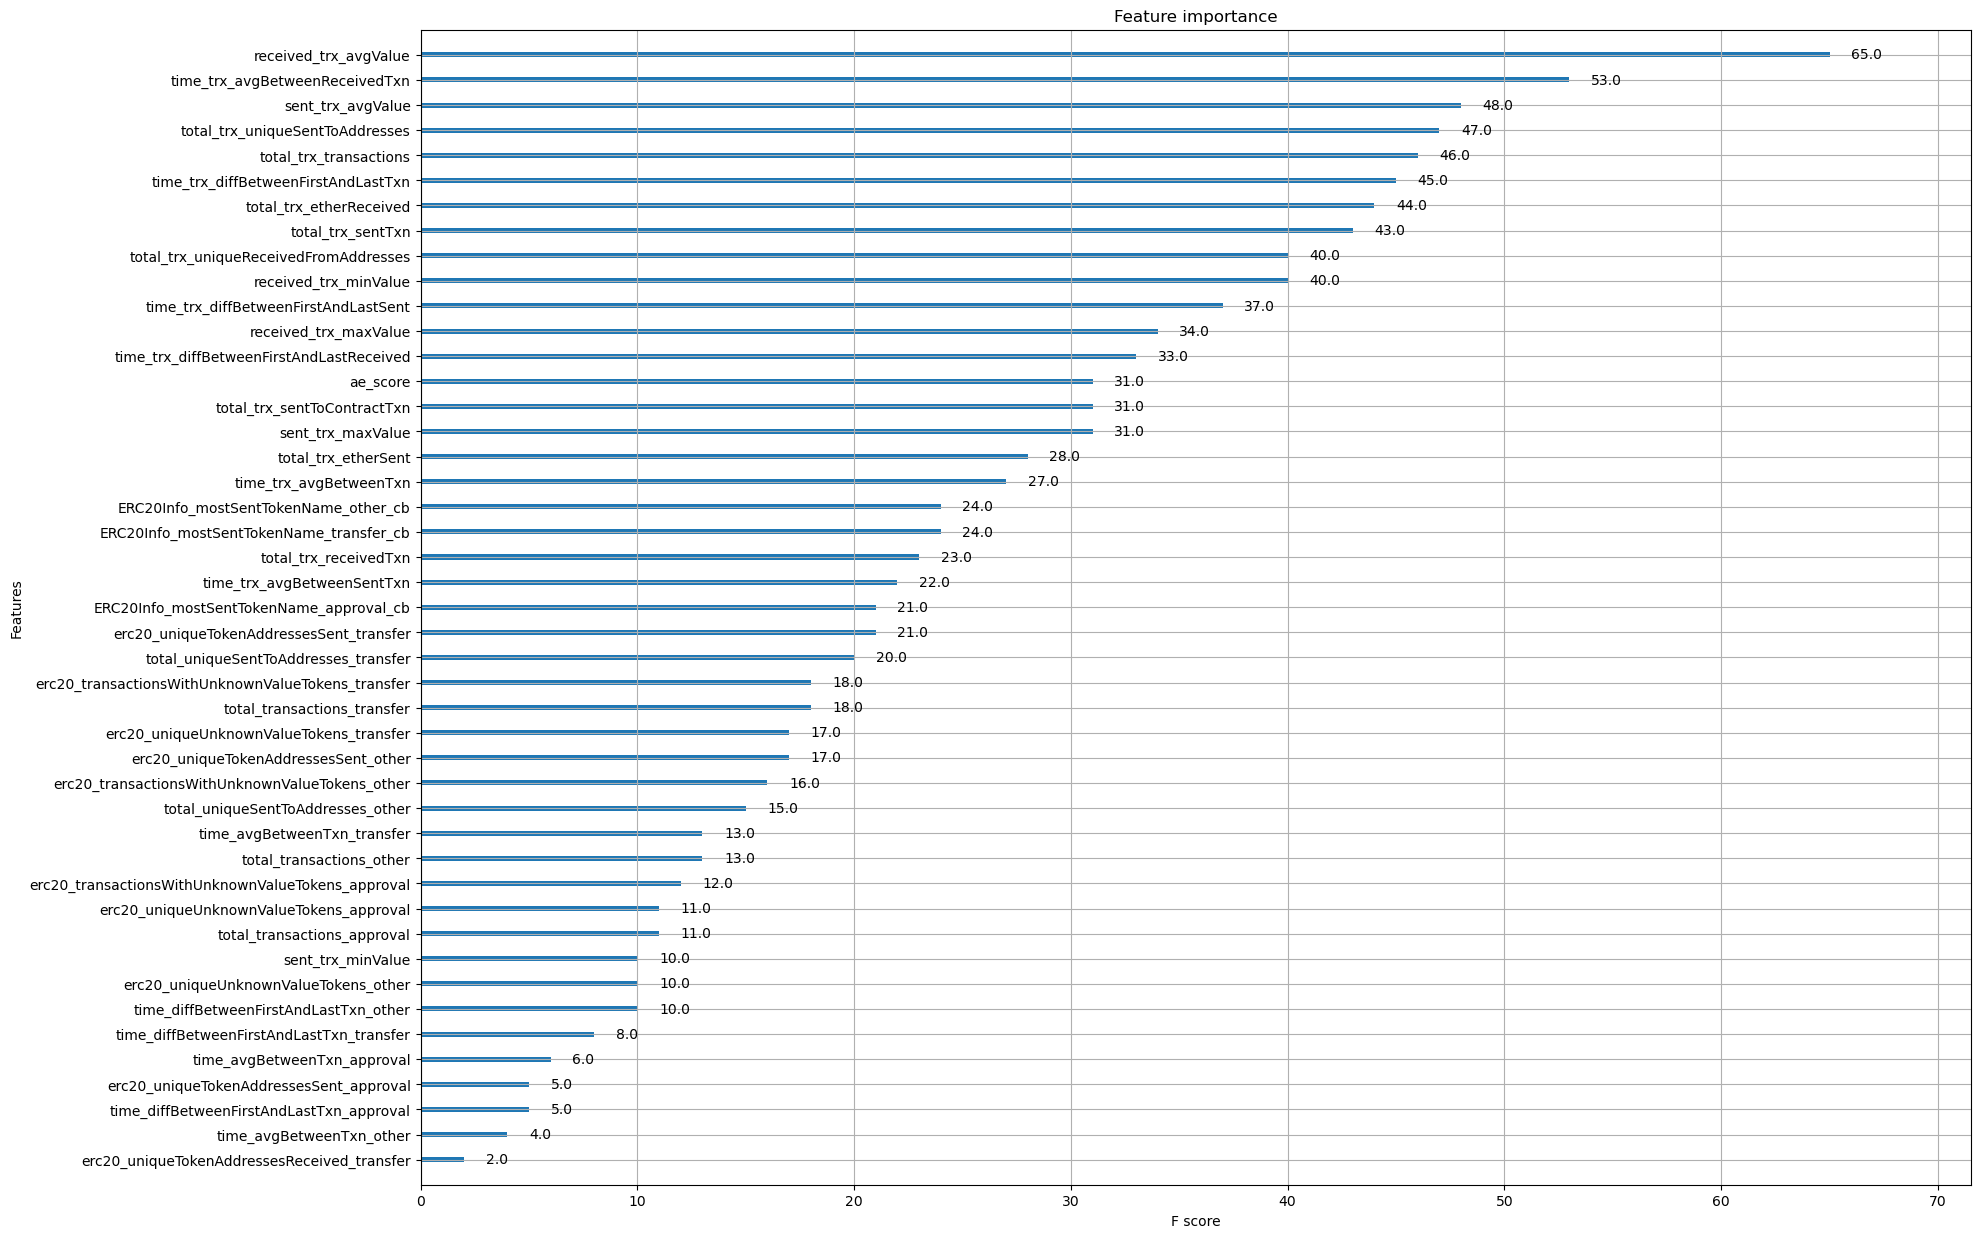

In [91]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
fig, ax = plt.subplots(figsize=(20, 15))
plot_importance(model, ax=ax)
plt.show()

In [83]:
#Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]
f = 'cover'
model.get_booster().get_score(importance_type= f)

{'total_transactions_other': 208.8929901123047,
 'total_uniqueSentToAddresses_other': 354.4469299316406,
 'time_avgBetweenTxn_other': 167.94097900390625,
 'time_diffBetweenFirstAndLastTxn_other': 316.01885986328125,
 'erc20_uniqueTokenAddressesSent_other': 275.70892333984375,
 'erc20_uniqueUnknownValueTokens_other': 489.07891845703125,
 'erc20_transactionsWithUnknownValueTokens_other': 311.25189208984375,
 'total_transactions_approval': 68.5374755859375,
 'time_avgBetweenTxn_approval': 81.59154510498047,
 'time_diffBetweenFirstAndLastTxn_approval': 30.611465454101562,
 'erc20_uniqueTokenAddressesSent_approval': 45.611000061035156,
 'erc20_uniqueUnknownValueTokens_approval': 137.08465576171875,
 'erc20_transactionsWithUnknownValueTokens_approval': 159.77578735351562,
 'total_transactions_transfer': 213.53387451171875,
 'total_uniqueSentToAddresses_transfer': 125.09326171875,
 'time_avgBetweenTxn_transfer': 127.98208618164062,
 'time_diffBetweenFirstAndLastTxn_transfer': 66.0402603149414